## Wrangling @dog_rates (WeRateDogs) tweets and related data

#### To do:
- Gather data from a variety of sources and in different formats
    * Import provided `twitter-archive-enhanced.csv` file from disk
    * Download the `image-predictions.tsv` file from Udacity using 
        __requets__ library
    * Call Twitter API to get full JSON objects for each `tweet_id` 
        in the provided archive and store to a single txt file
    * Read in the generated `tweet_json` file from the API call
- Assess and fix quality and tidiness of data
    * Find issues w/ the data
    * Fix them
- Showcase/analyze the complete, clean, and tidy dataset
    * Analyze the dataset to find any interesting relationships
        - Ratings over time
        - Ratings by type/name (doggo, floofer, pupper, puppo)
    * Visualize the findings

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import tweepy
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

## Gathering

In [2]:
# Read in the 'twitter_archive_enhanced.csv' file
df = pd.read_csv('twitter-archive-enhanced.csv', \
                 dtype={'in_reply_to_status_id': 'object', 'in_reply_to_user_id': 'object', \
                       'retweeted_status_id': 'object', 'retweeted_status_user_id': 'object'}, \
                 parse_dates=['timestamp', 'retweeted_status_timestamp'], \
                na_values=['', 'None'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          1611 non-null object
doggo                         97 non-null object
floofer                       10 non-null object
pupper                        257 non-null object
puppo                         30 non-null object
dtypes: datetime6

In [4]:
# Get the 'image_predictions.tsv' file from Udacity
predictions_link = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# Wrap in a try/except block in-case requests raises any exceptions
try:
    r = requests.get(predictions_link)
except requests.exceptions.RequestException as error:
    print(error)

In [5]:
# Needed to convert the string output of r.text to a StringIO object
# Based on https://stackoverflow.com/questions/22604564/create-pandas-dataframe-from-a-string
predictions_data = StringIO(r.text)

# Read in predictions_data as a tab-sepperated csv
image_predictions = pd.read_csv(predictions_data, sep='\t')

# Write 'image_predictions' out to disk
image_predictions.to_csv('image_predictions.tsv', sep='\t')

In [6]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [7]:
# Read in the app auth info needed for tweepy
with open('twitter_keys.txt', 'r+') as file:
    consumer_key = file.readline().rstrip()
    consumer_secret = file.readline().rstrip()
    access_token = file.readline().rstrip()
    access_secret = file.readline().rstrip()

# Setup tweepy for use
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [8]:
# Set the wait_on_rate_limit and *_limit_notify to True
api.wait_on_rate_limit = True
api.wait_on_rate_limit_notify = True

In [9]:
# Create an empty list to append the results of API call to
tweet_list = []

# Attempt to get all the data for the tweets in 'twitter-archive-enchanced' csv file
for tweet in df.tweet_id:
    # Wrap the get_status call in a try/except block to handle deleted tweets
    # and any other possble exceptions
    try:
        tweet_call = api.get_status(tweet, tweet_mode='extended')
    except:
        # On exception continue to next loop iteration
        continue
    tweet_list.append(tweet_call._json)
    

Rate limit reached. Sleeping for: 775
Rate limit reached. Sleeping for: 777


In [10]:
# Write out results of Twitter API call to a file
with open('tweet_json.txt', 'w+') as tweet_file:
    json.dump(tweet_list, tweet_file)
#     tweet_file.write('\n')

In [11]:
# Read in the `tweet_json.txt` file generated above
tweet_data = pd.read_json('tweet_json.txt', orient='records', typ='frame')

In [12]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 32 columns):
created_at                       2333 non-null datetime64[ns, UTC]
id                               2333 non-null int64
id_str                           2333 non-null int64
full_text                        2333 non-null object
truncated                        2333 non-null bool
display_text_range               2333 non-null object
entities                         2333 non-null object
extended_entities                2061 non-null object
source                           2333 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 non-null float64
in_reply_to_screen_name          77 non-null object
user                             2333 non-null object
geo                              0 non-null float64
coordinates                 

## Assessing

In [13]:
# Look at tweet_id and retweet/favorite counts
tweet_data[['id', 'retweet_count', 'favorite_count']].head()

,id,retweet_count,favorite_count
0,892420643555336193,7886,36972
1,892177421306343426,5856,31816
2,891815181378084864,3865,23969
3,891689557279858688,8048,40294
4,891327558926688256,8712,38499


In [14]:
# Examine the top 5 records in the provided csv file
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN


In [15]:
# See the NOT duplicated values of the source column
for index, row in df[~(df.source.duplicated())].iterrows():
    print(row.source)

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>


In [16]:
# See if any of the 'names' appear too often
df.name.value_counts()

a            55
Charlie      12
Lucy         11
Oliver       11
Cooper       11
             ..
Maude         1
Shnuggles     1
Stormy        1
Peanut        1
Danny         1
Name: name, Length: 956, dtype: int64

In [17]:
# Tweets that have extracted a 'name' of "a" should probably be set to None/NaN
df[df.name == 'a'].text[2352]

'This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx'

In [18]:
# Take a look at what the replies look like in the dataset
(df[~(df.in_reply_to_user_id.isna())])

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862663570751283e+17,2281181600.0,2017-07-15 16:51:35+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaT,NaN,12,10,NaN,NaN,NaN,NaN,NaN
55,881633300179243008,8.816070373140521e+17,47384430.0,2017-07-02 21:58:53+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaT,NaN,17,10,NaN,NaN,NaN,NaN,NaN
64,879674319642796034,8.795538273341727e+17,3105440746.0,2017-06-27 12:14:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaT,NaN,14,10,NaN,NaN,NaN,NaN,NaN
113,870726314365509632,8.707262027424932e+17,16487760.0,2017-06-02 19:38:25+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaT,NaN,10,10,NaN,NaN,NaN,NaN,NaN
148,863427515083354112,8.634256455687741e+17,77596200.0,2017-05-13 16:15:35+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaT,NaN,12,10,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715448741650022e+17,4196983835.0,2015-12-01 04:44:10+00:00,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaT,NaN,1,10,NaN,NaN,NaN,NaN,NaN
2149,669684865554620416,6.693543826270495e+17,4196983835.0,2015-11-26 01:11:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaT,NaN,11,10,NaN,NaN,NaN,NaN,NaN
2169,669353438988365824,6.678064545737605e+17,4196983835.0,2015-11-25 03:14:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,NaN,NaN,NaN,NaN
2189,668967877119254528,6.689207171325829e+17,21435658.0,2015-11-24 01:42:25+00:00,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\r\n@wane15,NaN,NaN,NaT,NaN,12,10,NaN,NaN,NaN,NaN,NaN


In [19]:
df[df.tweet_id == 671550332464455680].text

2038    After 22 minutes of careful deliberation this ...
Name: text, dtype: object

In [20]:
# Let's see what the numerator values are in the dataset
df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [21]:
# Looking at the tweets that have abnormally large ratings >=15
for index, row in df[df.rating_numerator >= 15].iterrows():
    print(row.tweet_id, '--', row.text, row.rating_numerator, '/', row.rating_denominator, '\n')

881633300179243008 -- @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s 17 / 10 

855862651834028034 -- @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research 420 / 10 

855860136149123072 -- @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10 666 / 10 

838916489579200512 -- RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI 15 / 10 

838150277551247360 -- @markhoppus 182/10 182 / 10 

838085839343206401 -- @bragg6of8 @Andy_Pace_ we are still looking for the first 15/10 15 / 10 

835246439529840640 -- @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho 960 / 0 

832215909146226688 -- RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu… 75 / 10 

820690176

In [22]:
# Similiratly let's check the denominator !=10
for index, row in df[df.rating_denominator != 10].iterrows():
    print(row.tweet_id, '--', row.text, row.rating_numerator, '/', row.rating_denominator, '\n')

835246439529840640 -- @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho 960 / 0 

832088576586297345 -- @docmisterio account started on 11/15/15 11 / 15 

820690176645140481 -- The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd 84 / 70 

810984652412424192 -- Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx 24 / 7 

775096608509886464 -- RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/… 9 / 11 

758467244762497024 -- Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE 165 / 150 

740373189193256964 -- After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 9 / 11 

73115602

In [23]:
# See if any of the tweets have more than one 'dog_stage' value
# Code based on: https://stackoverflow.com/questions/33158417/pandas-combine-two-strings-ignore-nan-values
(df.doggo.fillna('') + df.floofer.fillna('') + df.pupper.fillna('') + df.puppo.fillna('')).value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
dtype: int64

In [24]:
# Let's look at tweets w/ multiple 'dog_stage' entries
for index, row in df[((df.doggo == 'doggo') & (df.pupper == 'pupper')) | \
                     ((df.doggo == 'doggo') & (df.floofer == 'floofer')) | \
                     ((df.doggo == 'doggo') & (df.puppo == 'puppo'))].iterrows():
    print(row.tweet_id, '--', row.text, row.doggo, '/', row.pupper, '/', row.floofer, '/', row.puppo, '\n')

855851453814013952 -- Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel doggo / nan / nan / puppo 

854010172552949760 -- At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk doggo / nan / floofer / nan 

817777686764523521 -- This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7 doggo / pupper / nan / nan 

808106460588765185 -- Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho doggo / pupper / nan / nan 

802265048156610565 -- Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze doggo / pupper / nan / nan 

801115127852503040 -- This is Bones. He's

## Issues Found

#### Data Quality
1. There are re-tweets in the dataset. These should be ignored/removed.
2. There are replies in the dataset & they should also be ignored/removed.
3. The reply status ids also appear to have been rounded as the `in_reply_to_status_id` column values appear in scientific notation, even though the column was imported as a string. This could be addressed with the `tweet_json` data that was pulled from the Twitter API, but since I'm choosing to ignore/remove any replies before the analysis it will be moot.
4. Not all the tweets have a `name` for the dog(s). And the name `a` is present on 55 of the tweets. It should be set to `NaN`
5. The `source` column contains an entire HTML tag isntead of just the text to denote which client posted the tweet
6. Certain tweets have the wrong rating. Some of these are from re-tweets & replies; others are from group ratings (multiple dogs), but the following are wrong & should be corrected:

| tweet_id | current_rating | intended_rating |
|:---|---|---|
| `810984652412424192 ` | 24 | NaN |
| `786709082849828864` | 75 | 9.75 |
| `778027034220126208` | 27 | 11.27 | 
| `716439118184652801` | 50 | 11 |
| `680494726643068929` | 26 | 11.26 |
| `740373189193256964` | 9 | 14 |
| `722974582966214656` | 4 | 13 |
| `682962037429899265` | 7 | 10 |
| `666287406224695296` | 1 | 9 |

7. Similarly some of the denominator values are also questionable. Some of them are replies or re-tweets; and the group ratings are present as well, but the following need to be corrected:

| tweet_id | current_denominator | intended_denominator |
|:---|---|---|
| `810984652412424192 ` | 7 | NaN |
| `740373189193256964` | 11 | 10 |
| `722974582966214656` | 20 | 10 |
| `716439118184652801` | 50 | 10 |
| `682962037429899265` | 11 | 10 |
| `666287406224695296` | 2 | 10 |

8. There are 14 tweets that have more than a single `dog_stage` listed. They should be corrected to most accurate one for the image. The scenarios are:
    - `doggo` and `pupper`
    - `doggo` and `floofer`
    - `doggo` and `puppo`
    
    Some of them contain multiple/different dogs & the multiple instances of `dog_stage` are warranted. Those that need to be fixed are here:
    
| tweet_id | current_stage(s) | intended_stage(s) |
|:---|---|---|
| `855851453814013952` | doggo, puppo | puppo |
| `854010172552949760` | doggo, floofer | NaN |
| `817777686764523521` | doggo, pupper | pupper |
| `801115127852503040` | doggo, pupper | pupper |
| `785639753186217984` | doggo, pupper | doggo |
| `751583847268179968` | doggo, pupper | NaN |

    
    
9. The ratings are spread is spread across 2 columns `rating_numerator` and `rating_denominator`. A cleaner representation would be to calculate the actual normalized rating as a `float` to be able to make comparissons & analysis on the data and to account for multiple dogs per tweet.


#### Data Tidiness
1. The predictions of dog breed are not tidy. Each prediction should form it's own observation with the `breed` (or prediction of what's in the image), the `confidence` of the prediction, and whether or not the prediction is actually a `dog`
2. The `retweet_count` and `favorite_count` pulled in from the Twitter API are in sepparate table and should be merged with the master dataset
3. Dog stages (doggo, pupper, puppo, fluffo) are in sepparate columns and can be combined into a single tidy column `dog_stage`

In [25]:
# Check specific issues seen above
df[(df.tweet_id == 775096608509886464) | (df.tweet_id == 686035780142297088) | (df.tweet_id == 682808988178739200)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06+00:00,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.40373189193257e+17,4196983835.0,2016-06-08 02:41:38+00:00,https://twitter.com/dog_rates/status/740373189...,9,11,NaN,NaN,NaN,NaN,NaN
1598,686035780142297088,6.860340248008622e+17,4196983835.0,2016-01-10 04:04:10+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Yes I do realize a rating of 4/20 would've bee...,NaN,NaN,NaT,NaN,4,20,NaN,NaN,NaN,NaN,NaN
1663,682808988178739200,6.827884415375606e+17,4196983835.0,2016-01-01 06:22:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...","I'm aware that I could've said 20/16, but here...",NaN,NaN,NaT,NaN,20,16,NaN,NaN,NaN,NaN,NaN


## Cleaning - Fixing Identified Issues

In [26]:
# Dropping any re-tweets or replies from the dataframe
df.drop(df[~(df.in_reply_to_status_id.isna()) | ~(df.retweeted_status_id.isna())].index, axis=0, inplace=True)

In [27]:
# Make sure the 'in_reply_to_status_id' and 'retweeted_status_id' columns are now empty
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null object
in_reply_to_user_id           0 non-null object
timestamp                     2097 non-null datetime64[ns, UTC]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns, UTC]
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          1494 non-null object
doggo                         83 non-null object
floofer                       10 non-null object
pupper                        230 non-null object
puppo                         24 non-null object
dtypes: datetime64[ns, UT

In [28]:
# Fixing any instance of the dog's name being interperted as 'a'
df.loc[df.name == 'a', 'name'] = np.NaN

In [29]:
# Check to make sure it worked and that nothing else weird appears
df.name.value_counts()

Lucy       11
Charlie    11
Cooper     10
Oliver     10
Tucker      9
           ..
Kramer      1
Spark       1
Bloop       1
Bodie       1
Danny       1
Name: name, Length: 953, dtype: int64

In [30]:
# Fix having the entire HTML element in the 'source' column
# Using a regular expression. Modified from: 
# https://stackoverflow.com/questions/40942362/
df.source = df.source.str.extract(r'([^>]+)(?=<\/a>)')

In [31]:
# Check to make sure it worked as inteded
df.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

In [32]:
# Need to convert the 'rating_numerator' column to a float
df.rating_numerator = df.rating_numerator.astype('float64')
df.rating_denominator = df.rating_denominator.astype('float64')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null object
in_reply_to_user_id           0 non-null object
timestamp                     2097 non-null datetime64[ns, UTC]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns, UTC]
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null float64
rating_denominator            2097 non-null float64
name                          1439 non-null object
doggo                         83 non-null object
floofer                       10 non-null object
pupper                        230 non-null object
puppo                         24 non-null object
dtypes: datetime64[ns

In [34]:
# Setup correct values for rating numerators
numerators = {
    810984652412424192: np.NaN,
    786709082849828864: 9.75,
    778027034220126208: 11.27,
    716439118184652801: 11,
    680494726643068929: 11.26,
    740373189193256964: 14,
    722974582966214656: 13,
    682962037429899265: 10,
    666287406224695296: 9    
}

# And denominators
denominators = {
    810984652412424192: np.NaN,
    740373189193256964: 10,
    722974582966214656: 10,
    716439118184652801: 10,
    682962037429899265: 10,
    666287406224695296: 10
    
}

# As well as dog_stages
stages = {
    855851453814013952: 'puppo',
    854010172552949760: np.NaN,
    817777686764523521: 'pupper',
    801115127852503040: 'pupper',
    785639753186217984: 'doggo',
    751583847268179968: np.NaN
}

In [35]:
# Iterate over the rows in the 'numerators' dict & assign the values there
for index, row in df[df.tweet_id.isin(numerators)].iterrows():
    df.loc[df.tweet_id == row.tweet_id, 'rating_numerator'] = numerators[row.tweet_id]
    
# And do the same with the 'denominators'
for index, row in df[df.tweet_id.isin(denominators)].iterrows():
    df.loc[df.tweet_id == row.tweet_id, 'rating_denominator'] = denominators[row.tweet_id]

In [36]:
# Check to make sure it worked
df[(df.tweet_id.isin(numerators)) | (df.tweet_id.isin(denominators))]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23+00:00,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaT,"https://www.gofundme.com/sams-smile,https://tw...",NaN,NaN,Sam,NaN,NaN,NaN,NaN
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56+00:00,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,NaN,NaN,NaN,NaN
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34+00:00,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/778027034...,11.27,10.0,Sophie,NaN,NaN,pupper,NaN
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38+00:00,Twitter for iPhone,"After so many requests, this is Bretagne. She ...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/740373189...,14.00,10.0,NaN,NaN,NaN,NaN,NaN
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47+00:00,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/722974582...,13.00,10.0,NaN,NaN,NaN,NaN,NaN
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11+00:00,Twitter for iPhone,This is Bluebert. He just saw that both #Final...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/716439118...,11.00,10.0,Bluebert,NaN,NaN,NaN,NaN
1662,682962037429899265,NaN,NaN,2016-01-01 16:30:13+00:00,Twitter for iPhone,This is Darrel. He just robbed a 7/11 and is i...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/682962037...,10.00,10.0,Darrel,NaN,NaN,NaN,NaN
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00+00:00,Twitter for iPhone,Here we have uncovered an entire battalion of ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/680494726...,11.26,10.0,NaN,NaN,NaN,NaN,NaN
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11+00:00,Twitter for iPhone,This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666287406...,9.00,10.0,an,NaN,NaN,NaN,NaN


In [37]:
# Create a Series to merge with working dataframe
dog_stages = (df.doggo.fillna('') + df.floofer.fillna('') + df.pupper.fillna('') + df.puppo.fillna(''))

# Replace any empty string w/ a NaN
dog_stages.loc[dog_stages == ''] = np.NaN

# Rename the series to merge it with working dataframe
dog_stages = dog_stages.rename('dog_stage')

In [38]:
# Combine the 'dog_stages' Series with the dataframe
df = df.merge(dog_stages, left_index=True, right_index=True)

In [39]:
# Fix the 'dog_stage' values w/ multiple entries
for index, row in df[df.tweet_id.isin(stages)].iterrows():
    df.loc[df.tweet_id == row.tweet_id, 'dog_stage'] = stages[row.tweet_id]

In [40]:
# Check to see if it worked
# There are a couple of tweets that contain multiple dogs,
# So 'doggopupper' isn't surprising based on the analysis
df.dog_stage.value_counts()

pupper         223
doggo           73
puppo           24
floofer          9
doggopupper      5
Name: dog_stage, dtype: int64

In [41]:
# Replace the 'dog_stage' instances of 'doggopupper' with 'multiple'
df.loc[df.dog_stage == 'doggopupper', 'dog_stage'] = 'multiple'

In [42]:
# Check to see if it worked
df.dog_stage.value_counts()

pupper      223
doggo        73
puppo        24
floofer       9
multiple      5
Name: dog_stage, dtype: int64

In [43]:
# Create a normalized 'dog_rating'
df['rating'] = (df.rating_numerator / df.rating_denominator)

In [44]:
# Drop any extraneous columns
drop_cols = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', \
             'retweeted_status_user_id', 'retweeted_status_timestamp', 'rating_numerator', \
             'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo']

df.drop(columns=drop_cols, inplace=True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id         2097 non-null int64
timestamp        2097 non-null datetime64[ns, UTC]
source           2097 non-null object
text             2097 non-null object
expanded_urls    2094 non-null object
name             1439 non-null object
dog_stage        334 non-null object
rating           2096 non-null float64
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(5)
memory usage: 227.4+ KB


In [46]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,NaN,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,NaN,1.3
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,NaN,1.2
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,NaN,1.3
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,NaN,1.2


In [47]:
# Merge in the retweet and favorite counts from the Twitter API call
df = df.merge(tweet_data[['id', 'retweet_count', 'favorite_count']], \
                    how='left', right_on='id', left_on='tweet_id')

In [48]:
# Drop the duplicate 'id' column from the 'tweet_data' dataframe
df.drop(columns='id', inplace=True)

### Check to see if any of the tweets don't have a 'retweet_count' or 'favorite_count'
These would be tweets that have since been deleted & thus the API call did not retrieve anything for them.

In [49]:
df[(df.retweet_count.isna()) | (df.favorite_count.isna())]

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,rating,retweet_count,favorite_count
90,872261713294495745,2017-06-07 01:19:32+00:00,Twitter for iPhone,This is Harry. His ears are activated one at a...,https://twitter.com/dog_rates/status/872261713...,Harry,NaN,1.3,NaN,NaN
202,844704788403113984,2017-03-23 00:18:10+00:00,Twitter for iPhone,This is Luna. It's her first time outside and ...,https://twitter.com/dog_rates/status/844704788...,Luna,NaN,1.3,NaN,NaN
234,837366284874571778,2017-03-02 18:17:34+00:00,Twitter for iPhone,This is Lucy. She has a portrait of herself on...,https://twitter.com/dog_rates/status/837366284...,Lucy,NaN,1.3,NaN,NaN
284,829374341691346946,2017-02-08 17:00:26+00:00,Twitter for iPhone,This is Astrid. She's a guide doggo in trainin...,https://twitter.com/dog_rates/status/829374341...,Astrid,doggo,1.3,NaN,NaN
575,779123168116150273,2016-09-23 01:00:13+00:00,Twitter for iPhone,This is Reggie. He hugs everyone he meets. 12/...,https://twitter.com/dog_rates/status/779123168...,Reggie,NaN,1.2,NaN,NaN
727,754011816964026368,2016-07-15 17:56:40+00:00,Twitter for iPhone,This is Charlie. He pouts until he gets to go ...,https://twitter.com/dog_rates/status/754011816...,Charlie,NaN,1.2,NaN,NaN
1488,680055455951884288,2015-12-24 16:00:30+00:00,TweetDeck,"Meet Sammy. At first I was like ""that's a snow...",https://twitter.com/dog_rates/status/680055455...,Sammy,NaN,1.0,NaN,NaN


In [50]:
# Wrtie out the 'master' dataframe to a file
df.to_csv('twitter_archive_master.csv', index=False)

In [51]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [52]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [53]:
# See how many of the 'image_predictions' are not a dog
image_predictions[(image_predictions.p1_dog == False) & \
                  (image_predictions.p2_dog == False) & \
                  (image_predictions.p3_dog == False)].shape[0]

324

In [54]:
# Attempt to use the melt() function to convert the 'image_predictions' data to a more tidy format
pd.melt(image_predictions, id_vars=['tweet_id', 'jpg_url', 'img_num'], value_vars=['p1', 'p2', 'p3'], \
        var_name='prediction_run', value_name='prediction')

,tweet_id,jpg_url,img_num,prediction_run,prediction
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p1,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,p1,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,p1,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,p1,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,p1,miniature_pinscher
...,...,...,...,...,...
6220,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,p3,German_short-haired_pointer
6221,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,p3,spatula
6222,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,p3,kelpie
6223,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,p3,papillon


In [55]:
# Since melt() wasn't able to provide the desired result,
# rename columns for use in wide_to_long() function
image_predictions.rename(columns={'p1': 'p1_pred', 'p2': 'p2_pred', 'p3': 'p3_pred'}, inplace=True)

In [56]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1_pred     2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2_pred     2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3_pred     2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [57]:
# Convert the wide 'image_predictions' data from a wide to a long (tidy) dataframe
tidy_predictions = pd.wide_to_long(image_predictions,
                i=['tweet_id', 'jpg_url', 'img_num'],
                j='var',
                stubnames=['p1', 'p2', 'p3'],
                sep="_",
                suffix='\D+').reset_index()

### Look at the results

There is now 3 records for each tweet & a column for each prediction. There's a sepparate row for the prediction, confidence, and whether or not the prediction is a dog

In [58]:
tidy_predictions.head(9)

,tweet_id,jpg_url,img_num,var,p1,p2,p3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,pred,Welsh_springer_spaniel,collie,Shetland_sheepdog
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,conf,0.465074,0.156665,0.0614285
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,dog,True,True,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,pred,redbone,miniature_pinscher,Rhodesian_ridgeback
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,conf,0.506826,0.0741917,0.07201
5,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,dog,True,True,True
6,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,pred,German_shepherd,malinois,bloodhound
7,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,conf,0.596461,0.138584,0.116197
8,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,dog,True,True,True


In [59]:
# See what is the most common prediction
tidy_predictions[(tidy_predictions['var'] == 'pred')].p1.value_counts()

golden_retriever            150
Labrador_retriever          100
Pembroke                     89
Chihuahua                    83
pug                          57
                           ... 
guenon                        1
sulphur-crested_cockatoo      1
tricycle                      1
flamingo                      1
harp                          1
Name: p1, Length: 378, dtype: int64

In [60]:
# Write out predictions datafram to a file
tidy_predictions.to_csv('tidy_predictions.csv', index=False)

## Visualizing the Results

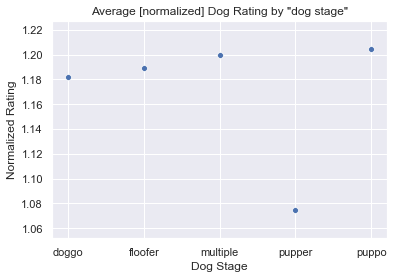

In [61]:
# Get the average rating of dogs by their 'dog_stage'
avg_rating_by_dog_stage = df.groupby('dog_stage')['rating'].mean()

sns.set(style="darkgrid")

# Plot the data as a scatter plot to show how the ratings are distributed
sns.scatterplot(avg_rating_by_dog_stage.index, avg_rating_by_dog_stage)
plt.xlabel('Dog Stage')
plt.ylabel('Normalized Rating')
plt.title('Average [normalized] Dog Rating by "dog stage"');

In [62]:
# See how many tweets have a rating > 10 that could be causing issues
df[df.rating > 10]

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,rating,retweet_count,favorite_count
770,749981277374128128,2016-07-04 15:00:45+00:00,TweetDeck,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,Atticus,NaN,177.6,2515.0,5237.0
1821,670842764863651840,2015-11-29 05:52:33+00:00,Twitter for iPhone,After so many requests... here you go.\r\n\r\n...,https://twitter.com/dog_rates/status/670842764...,NaN,NaN,42.0,8530.0,24258.0


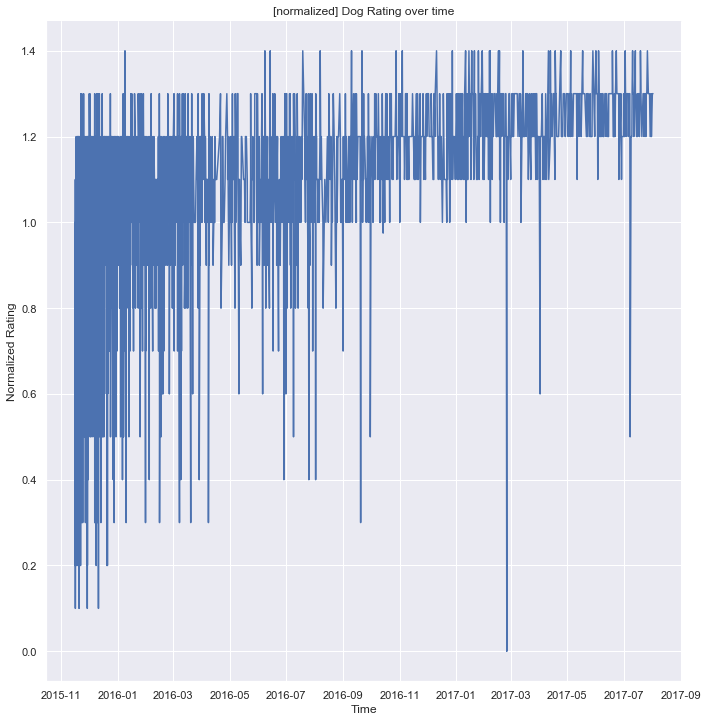

In [65]:
# Drop outliers that make the plot readable
no_outliers = df.drop(df[df.rating > 10].index)

# Plot the data as a scatter plot to show how the ratings are distributed
sns.relplot(x='timestamp', y='rating', height=10, kind='line', data=no_outliers)

plt.xlabel('Time')
plt.ylabel('Normalized Rating')
plt.title('[normalized] Dog Rating over time');

### Summary of Vizualization

1. Looking at the scatter plot of the average rating by `dog_stage` shows that most of the different types get a similar rating of between `1.18` and `1.20` while the `pupper` stage on average get's only `1.08` rating.


2. Looking at ratings over time shows that the ratings have standardized around a normalized value of `1.2`. While there was a lot of variability in the ratings initially, over time the amount of lower ratings has become very rare.